<a href="https://colab.research.google.com/github/Lohitasrith01/Multi-Agent-Autonomous-Drone-Navigation-Using-Reinforcement-Learning-in-AirSim-/blob/main/ppo_training_and_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install gymnasium
!pip install stable_baselines3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 7.9 MB/s eta 0:00:00


# Multi Agent Environment Definition

In [ ]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt


class MultiAgentEnv(gym.Env):
    def __init__(self, num_agents=2, width=8, height=8, obstacle_count=2):
        super(MultiAgentEnv, self).__init__()
        self.num_agents = num_agents
        self.width = width
        self.height = height
        self.obstacle_count = obstacle_count

        # Action space: 4 actions for each agent (up, down, left, right)
        self.action_space = spaces.MultiDiscrete([4] * num_agents)

        # Observation space: Each agent's grid position (flattened index) and goal status (this needs to be fixed)
        self.observation_space = spaces.Box(
            low=0, high=max(width * height - 1, 1), shape=(num_agents, 2), dtype=np.int32
        )

        # Initialize positions, goals, and obstacles
        self.agent_positions = np.zeros((num_agents, 2), dtype=np.int32)
        self.goal_positions = []
        self.obstacle_positions = []
        self.agents_at_goals = [False] * self.num_agents
        self.steps_taken = 0

    def reset(self, seed=None):
        if seed is not None:
            np.random.seed(seed)

        self.agent_positions = np.array([[0, 0] for _ in range(self.num_agents)], dtype=np.int32)
        self.obstacle_positions = [self.random_position(avoid=[tuple(pos) for pos in self.agent_positions]) for _ in range(self.obstacle_count)]
        avoid_positions = [tuple(pos) for pos in self.agent_positions] + self.obstacle_positions
        self.goal_positions = [self.random_position(avoid=avoid_positions) for _ in range(self.num_agents)]
        self.agents_at_goals = [False] * self.num_agents
        self.steps_taken = 0

        obs = self.get_state()
        info = {}
        return obs, info

    def step(self, actions):
      rewards = np.zeros(self.num_agents, dtype=np.float32)  # Separate rewards for each agent
      terminated = np.zeros(self.num_agents, dtype=bool)
      truncated = False

      for i, action in enumerate(actions):
          # If the agent is already at its goal, skip movement
          if self.agents_at_goals[i]:
              rewards[i] += 0  # No additional reward for staying at goal
              terminated[i] = True  # Agent is terminated (goal reached)
              continue

          # Move the agent based on the action
          if action == 0 and self.agent_positions[i][1] > 0:  # Up
              self.agent_positions[i][1] -= 1
          elif action == 1 and self.agent_positions[i][1] < self.height - 1:  # Down
              self.agent_positions[i][1] += 1
          elif action == 2 and self.agent_positions[i][0] > 0:  # Left
              self.agent_positions[i][0] -= 1
          elif action == 3 and self.agent_positions[i][0] < self.width - 1:  # Right
              self.agent_positions[i][0] += 1

          # Check if agent hits its goal
          if tuple(self.agent_positions[i]) == self.goal_positions[i]:
              self.agents_at_goals[i] = True
              rewards[i] += 50  # Goal reward
              terminated[i] = True  # Mark agent as terminated

          # Check collisions with obstacles
          if tuple(self.agent_positions[i]) in self.obstacle_positions:
              rewards[i] -= 20  # Obstacle penalty
              self.agent_positions[i] = [0, 0]  # Reset position on collision

          # Check collisions with other agents
          for j in range(self.num_agents):
              if i != j and np.array_equal(self.agent_positions[i], self.agent_positions[j]):
                  rewards[i] -= 20  # Collision penalty
                  rewards[j] -= 20
                  self.agent_positions[i] = [0, 0]  # Reset position on collision
                  self.agent_positions[j] = [0, 0]

      # Penalize step to encourage efficiency
      rewards -= 1
      self.steps_taken += 1

      # Overall episode termination if all agents have reached their goals
      all_agents_terminated = all(self.agents_at_goals)
      truncated = self.steps_taken >= 100

      obs = self.get_state()
      info = {}

      return obs, rewards, terminated, truncated or all_agents_terminated, info



    def get_state(self):
        grid_indices = np.array([pos[0] * self.width + pos[1] for pos in self.agent_positions], dtype=np.float32)
        goal_status = np.array([1.0 if reached else 0.0 for reached in self.agents_at_goals], dtype=np.float32)
        return np.stack((grid_indices, goal_status), axis=-1)

    def render(self, mode='human'):
        grid = np.full((self.height, self.width), '.', dtype=str)
        for pos in self.obstacle_positions:
            grid[pos[1], pos[0]] = 'O'
        for i, goal in enumerate(self.goal_positions):
            grid[goal[1], goal[0]] = f'G{i}'
        for i, agent in enumerate(self.agent_positions):
            grid[agent[1], agent[0]] = f'A{i}' if not self.agents_at_goals[i] else 'AG'

        print("\n".join(" ".join(row) for row in grid))
        print()

    def random_position(self, avoid=None):
        while True:
            position = tuple(np.random.randint(self.width, size=2))
            if avoid is None or position not in avoid:
                return position


# MADDPG Design and Training

Episode 1/500, Total Reward: -1230.0
Episode 2/500, Total Reward: -390.0
Episode 3/500, Total Reward: -42.0
Episode 4/500, Total Reward: -530.0
Episode 5/500, Total Reward: -1860.0
Episode 6/500, Total Reward: -790.0
Episode 7/500, Total Reward: -2060.0
Episode 8/500, Total Reward: -1710.0
Episode 9/500, Total Reward: -3650.0
Episode 10/500, Total Reward: 6.0
Episode 11/500, Total Reward: 34.0
Episode 12/500, Total Reward: -42.0
Episode 13/500, Total Reward: -1570.0
Episode 14/500, Total Reward: -3380.0
Episode 15/500, Total Reward: 72.0
Episode 16/500, Total Reward: -2420.0
Episode 17/500, Total Reward: -1586.0
Episode 18/500, Total Reward: -930.0
Episode 19/500, Total Reward: -1060.0
Episode 20/500, Total Reward: -4580.0
Episode 21/500, Total Reward: -178.0
Episode 22/500, Total Reward: -1370.0
Episode 23/500, Total Reward: -2630.0
Episode 24/500, Total Reward: -212.0
Episode 25/500, Total Reward: -1290.0
Episode 26/500, Total Reward: -2430.0
Episode 27/500, Total Reward: -950.0
Epis

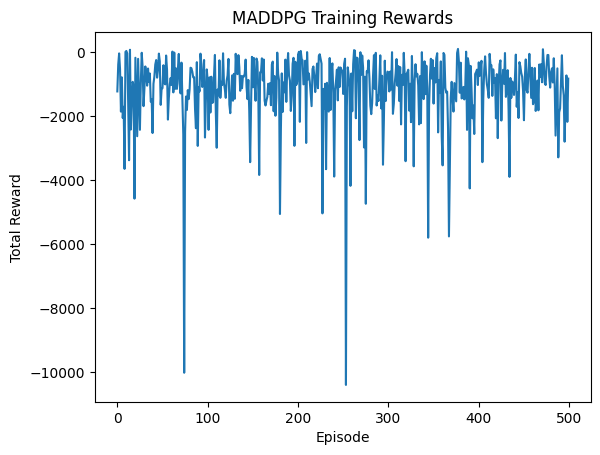

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random


# Actor Network
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_dim)  # Outputs probabilities for actions

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        return torch.softmax(self.fc3(x), dim=-1)


class Critic(nn.Module):
    def __init__(self, state_dim, action_dim, num_agents):
        super(Critic, self).__init__()
        input_dim = state_dim * num_agents + action_dim * num_agents
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 1)  # Outputs Q-value

    def forward(self, states, actions):
        # Debugging shapes
        #print(f"Critic Input States Shape: {states.shape}")
        #print(f"Critic Input Actions Shape: {actions.shape}")

        x = torch.cat([states, actions], dim=-1)
        #print(f"Critic Concatenated Input Shape: {x.shape}")  # Debug concatenated input shape

        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)



# Replay Buffer
class ReplayBuffer:
    def __init__(self, max_size=100000):
        self.buffer = deque(maxlen=max_size)

    def add(self, experience):
        self.buffer.append(experience)

    def sample(self, batch_size):
      batch = random.sample(self.buffer, batch_size)
      states, actions, rewards, next_states, dones = zip(*batch)

      return (
          torch.FloatTensor(np.array(states)),       # Shape: (batch_size, num_agents, state_dim)
          torch.LongTensor(np.array(actions)),       # Shape: (batch_size, num_agents) for discrete actions
          torch.FloatTensor(np.array(rewards)),      # Shape: (batch_size, num_agents)
          torch.FloatTensor(np.array(next_states)),  # Shape: (batch_size, num_agents, state_dim)
          torch.FloatTensor(np.array(dones)),        # Shape: (batch_size, num_agents)
      )


    def __len__(self):
        return len(self.buffer)


# MADDPG Algorithm
class MADDPG:
    def __init__(self, num_agents, state_dim, action_dim, lr_actor=1e-3, lr_critic=1e-3,lr=1e-3, gamma=0.99):
        self.num_agents = num_agents
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.gamma = gamma

        # Initialize actor and critic networks for each agent
        self.actors = [Actor(state_dim, action_dim) for _ in range(num_agents)]
        self.critics = [Critic(state_dim, action_dim, num_agents) for _ in range(num_agents)]

        # Target networks
        self.actors_target = [Actor(state_dim, action_dim) for _ in range(num_agents)]
        self.critics_target = [Critic(state_dim, action_dim, num_agents) for _ in range(num_agents)]

        # Optimizers
        self.actor_optimizers = [optim.Adam(actor.parameters(), lr=lr) for actor in self.actors]
        self.critic_optimizers = [optim.Adam(critic.parameters(), lr=lr) for critic in self.critics]

        # Replay buffer
        self.replay_buffer = ReplayBuffer()

        # Copy initial weights to target networks
        for actor, actor_target in zip(self.actors, self.actors_target):
            actor_target.load_state_dict(actor.state_dict())
        for critic, critic_target in zip(self.critics, self.critics_target):
            critic_target.load_state_dict(critic.state_dict())

    def act(self, state):
        actions = []
        for i, actor in enumerate(self.actors):
            # State preprocessing: Select agent-specific state component
            agent_state = torch.FloatTensor(state[i])  # Extract state for agent i
            action_probs = torch.softmax(actor(agent_state), dim=-1).detach().numpy()
            action = np.random.choice(self.action_dim, p=action_probs)  # Sample action
            actions.append(action)
        return actions

    def update(self, batch_size=64):
      if len(self.replay_buffer) < batch_size:
          return  # Not enough samples to update

      # Sample a batch from the replay buffer
      states, actions, rewards, next_states, dones = self.replay_buffer.sample(batch_size)
      #print(f"States Shape: {states.shape}, Actions Shape: {actions.shape}")
      #print(f"Rewards Shape: {rewards.shape}, Dones Shape: {dones.shape}")

      for agent_idx in range(self.num_agents):
          # Update Critic
          with torch.no_grad():
              # Compute target Q-value
              next_actions = torch.cat(
                  [torch.softmax(actor(next_states[:, i, :]), dim=-1).detach() for i, actor in enumerate(self.actors_target)],
                  dim=-1,
              )
              #print(f"Next Actions Shape: {next_actions.shape}")

              next_critic_input = torch.cat([next_states.view(batch_size, -1), next_actions], dim=-1)
              target_q = rewards[:, agent_idx].view(-1, 1) + \
                        self.gamma * (1 - dones[:, agent_idx].view(-1, 1)) * \
                        self.critics_target[agent_idx](next_states.view(batch_size, -1), next_actions)

          # One-hot encode current actions
          actions_onehot = torch.zeros(batch_size, self.num_agents, self.action_dim)
          actions_onehot.scatter_(-1, actions.unsqueeze(-1), 1)  # Convert to one-hot

          critic_input = torch.cat([states.view(batch_size, -1), actions_onehot.view(batch_size, -1)], dim=-1)
          current_q = self.critics[agent_idx](states.view(batch_size, -1), actions_onehot.view(batch_size, -1))
          critic_loss = nn.MSELoss()(current_q, target_q)

          #print(f"Critic Loss for Agent {agent_idx}: {critic_loss.item()}")

          self.critic_optimizers[agent_idx].zero_grad()
          critic_loss.backward()
          self.critic_optimizers[agent_idx].step()

          # Update Actor
          actor_input = states[:, agent_idx, :]
          predicted_actions = torch.softmax(self.actors[agent_idx](actor_input), dim=-1)
          predicted_actions_onehot = torch.zeros_like(actions_onehot)
          #predicted_actions_onehot.scatter_(-1, predicted_actions.argmax(dim=-1, keepdim=True), 1)

          actor_loss = -self.critics[agent_idx](
              states.view(batch_size, -1),
              predicted_actions_onehot.view(batch_size, -1)
          ).mean()

          #print(f"Actor Loss for Agent {agent_idx}: {actor_loss.item()}")

          self.actor_optimizers[agent_idx].zero_grad()
          actor_loss.backward()
          self.actor_optimizers[agent_idx].step()







def train_maddpg(env, agent, episodes=500, batch_size=64):
    rewards_per_episode = []

    for episode in range(episodes):
        obs, _ = env.reset()
        total_reward = 0

        while True:
            # Get actions from the agent
            actions = agent.act(obs)

            # Perform actions in the environment
            next_obs, rewards, terminated, episode_done, _ = env.step(actions)
            # Add experience to replay buffer
            agent.replay_buffer.add((obs, actions, rewards, next_obs, terminated))

            # Update the agent
            agent.update(batch_size)

            # Accumulate rewards and update observation
            total_reward += np.sum(rewards)
            obs = next_obs

            # Check if episode is done (global termination signal)
            if episode_done:
                break

        # Record total reward for this episode
        rewards_per_episode.append(total_reward)
        print(f"Episode {episode + 1}/{episodes}, Total Reward: {total_reward}")

    return rewards_per_episode





# Plotting Function
def plot_rewards(rewards):
    plt.plot(rewards)
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("MADDPG Training Rewards")
    plt.show()


# Run Training
if __name__ == "__main__":


    env = MultiAgentEnv(num_agents=2, width=5, height=5, obstacle_count=2)
    agent = MADDPG(num_agents=2, state_dim=2, action_dim=4)

    rewards = train_maddpg(env, agent)
    plot_rewards(rewards)


# Testing the Trained model by choosing optimal Policy

Test Episode 1/10, Total Reward: -10200.0
Test Episode 2/10, Total Reward: -200.0
Test Episode 3/10, Total Reward: -200.0
Test Episode 4/10, Total Reward: -200.0
Test Episode 5/10, Total Reward: -200.0
Test Episode 6/10, Total Reward: -200.0
Test Episode 7/10, Total Reward: -200.0
Test Episode 8/10, Total Reward: -200.0
Test Episode 9/10, Total Reward: -200.0
Test Episode 10/10, Total Reward: -200.0


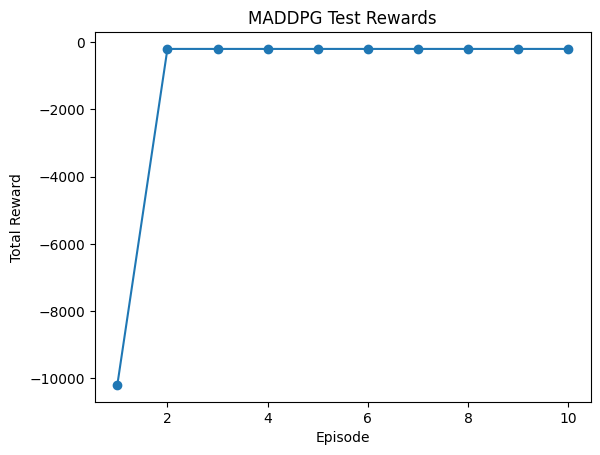

In [ ]:
import matplotlib.pyplot as plt

def test_maddpg(env, agent, episodes=10):
    rewards_per_episode = []

    for episode in range(episodes):
        obs, _ = env.reset()
        total_reward = 0

        while True:
            actions = []
            for i, actor in enumerate(agent.actors):
                with torch.no_grad():
                    # Select the most probable action
                    agent_state = torch.FloatTensor(obs[i])
                    action_probs = actor(agent_state)
                    action = torch.argmax(action_probs).item()
                    actions.append(action)

            # Perform actions in the environment
            next_obs, rewards, terminated, episode_done, _ = env.step(actions)

            # Accumulate rewards
            total_reward += np.sum(rewards)

            # Update observation
            obs = next_obs

            # Check if episode is done
            if episode_done:
                break

        # Record total reward for this episode
        rewards_per_episode.append(total_reward)
        print(f"Test Episode {episode + 1}/{episodes}, Total Reward: {total_reward}")

    return rewards_per_episode


# Plotting Function for Testing
def plot_test_rewards(rewards):
    plt.plot(range(1, len(rewards) + 1), rewards, marker='o')
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("MADDPG Test Rewards")
    plt.show()


# Run Testing
if __name__ == "__main__":
    test_rewards = test_maddpg(env, agent)
    plot_test_rewards(test_rewards)

# Hyper Parameter Tuning using Optuna on the MADDPG model

In [ ]:
!pip install optuna
import optuna
import numpy as np
import matplotlib.pyplot as plt

def train_with_hyperparams(trial):
    # Define hyperparameters to tune
    lr_actor = trial.suggest_loguniform("lr_actor", 1e-5, 1e-2)
    lr_critic = trial.suggest_loguniform("lr_critic", 1e-5, 1e-2)
    gamma = trial.suggest_uniform("gamma", 0.9, 0.999)
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])
    replay_buffer_size = trial.suggest_int("replay_buffer_size", 50000, 200000, step=50000)

    # Set up the environment and MADDPG model
    env = MultiAgentEnv(num_agents=2, width=10, height=10, obstacle_count=3)
    agent = MADDPG(
        num_agents=2,
        state_dim=2,
        action_dim=4,
        lr_actor=lr_actor,
        lr_critic=lr_critic,
        gamma=gamma,

    )
    agent.replay_buffer = ReplayBuffer(max_size=replay_buffer_size)
    # Training loop
    episodes = 100  # Number of episodes for evaluation
    rewards_per_episode = []

    for episode in range(episodes):
        obs, _ = env.reset()
        total_reward = 0

        while True:
            actions = agent.act(obs)
            next_obs, rewards, terminated, truncated, _ = env.step(actions)
            agent.replay_buffer.add((obs, actions, rewards, next_obs, terminated))
            agent.update(batch_size)
            total_reward += np.sum(rewards)
            obs = next_obs

            if all(terminated) or truncated:
                break

        rewards_per_episode.append(total_reward)

    # Return the average reward over the episodes
    return np.mean(rewards_per_episode)

# Create Optuna study
study = optuna.create_study(direction="maximize")
study.optimize(train_with_hyperparams, n_trials=20)

# Display the best hyperparameters
print("Best Hyperparameters:", study.best_params)

# Plot the optimization history
optuna.visualization.plot_optimization_history(study).show()

# Plot the hyperparameter importance
optuna.visualization.plot_param_importances(study).show()


[I 2024-12-04 01:07:25,948] A new study created in memory with name: no-name-034fd767-eae8-4812-aaf2-b9ff0da4c205
<ipython-input-10-7411cbcf4770>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr_actor = trial.suggest_loguniform("lr_actor", 1e-5, 1e-2)
<ipython-input-10-7411cbcf4770>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr_critic = trial.suggest_loguniform("lr_critic", 1e-5, 1e-2)
<ipython-input-10-7411cbcf4770>:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform("gamma", 0.9, 0.999)
[I 2

Best Hyperparameters: {'lr_actor': 0.0024081803485624877, 'lr_critic': 0.0005103534250748405, 'gamma': 0.9299198124998123, 'batch_size': 128, 'replay_buffer_size': 50000}
